<a href="https://colab.research.google.com/github/der-himmel/obr-iz/blob/main/recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [257]:
! pip install albumentations opencv-python

In [258]:
import numpy as np
import cv2
from skimage import io
import matplotlib.pyplot as plt
import albumentations as A
from scipy.interpolate import interp1d

In [259]:
def preprocess_image(image_path):
    image = io.imread(image_path)
    height, width = image.shape[:2]

    padding = max(width, height)
    padded_image = cv2.copyMakeBorder(image, padding, padding, padding, padding, borderType=cv2.BORDER_CONSTANT, value=(255, 255, 255))
    transform = A.Compose([
      A.HorizontalFlip(p=0.8),
      A.VerticalFlip(p=0.1),
      A.Rotate(limit=(0, 90), p=1.0),
      # A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),
      # A.Blur(blur_limit=3, p=0.1),
      A.Perspective(scale=(0.001, 0.075), p=0.5),
      A.ElasticTransform(alpha=0.01, sigma=10.0, p=0.5),
      A.GridDistortion(num_steps=25, distort_limit=(-0.25, 0.25), p=0.5),
    ])

    image = transform(image=padded_image)['image']

    return image

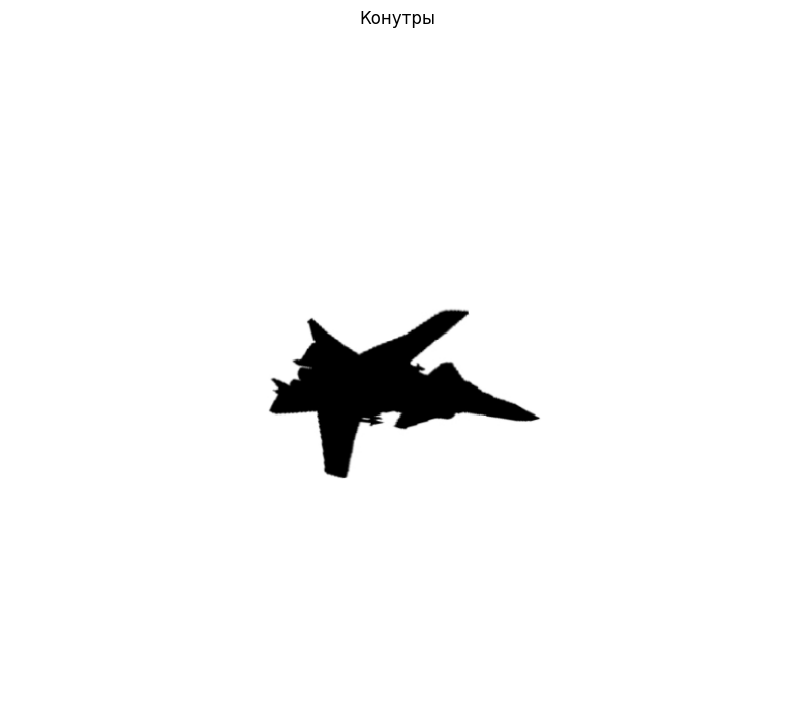

In [260]:
PATH = 'berkut-256.jpg'
# PATH = 'test-img/cg-test2.jpg'

image = preprocess_image(PATH)

all_characteristic_points = []

plt.figure(figsize=(10, 10))
plt.imshow(image, cmap='gray'), plt.axis('off'), plt.title('Конутры')
plt.show()

In [261]:
# output_image = np.zeros_like(binary_image)

# cv2.circle(output_image, tuple(center_of_gravity.astype(int)), 1, (255, 0, 0), -1)
# cv2.drawContours(output_image, contours[::-1], -1, (255), thickness=1)

# plt.figure(figsize=(10, 10))
# plt.imshow(output_image, cmap='gray'), plt.axis('off'), plt.title('Конутры')
# plt.show()

In [262]:
def binarize_image(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    _, binary_image = cv2.threshold(gray_image, 127, 255, cv2.THRESH_BINARY_INV)

    return binary_image

In [263]:
# def normalize_contour(contour, target_height=256):
#     center_of_gravity = np.mean(contour, axis=0)
#     centered_contour = contour - center_of_gravity

#     p1 = centered_contour[0]
#     angle = np.arctan2(p1[1], p1[0])

#     rotation_matrix = np.array([[np.cos(-angle), -np.sin(-angle)],
#                                 [np.sin(-angle), np.cos(-angle)]])
#     rotated_contour = np.dot(centered_contour, rotation_matrix)

#     height = np.max(rotated_contour[:, 1]) - np.min(rotated_contour[:, 1])
#     scale_factor = target_height / height
#     scaled_contour = rotated_contour * scale_factor
#     width = np.max(scaled_contour[:, 0]) - np.min(scaled_contour[:, 0])
#     scale_width = scale_factor * (width / height)
#     scaled_contour[:, 0] *= scale_width

#     n_points = 256
#     y = scaled_contour[:, 1]
#     x = scaled_contour[:, 0]

#     f_y = interp1d(np.linspace(0, 1, len(y)), y, kind='linear')
#     f_x = interp1d(np.linspace(0, 1, len(x)), x, kind='linear')

#     new_y = f_y(np.linspace(0, 1, n_points))
#     new_x = f_x(np.linspace(0, 1, n_points))

#     normalized_contour = np.column_stack((new_x, new_y))
#     print(normalized_contour)

#     return normalized_contour, int(width), target_height

CG = [373.05307856 348.60084926]


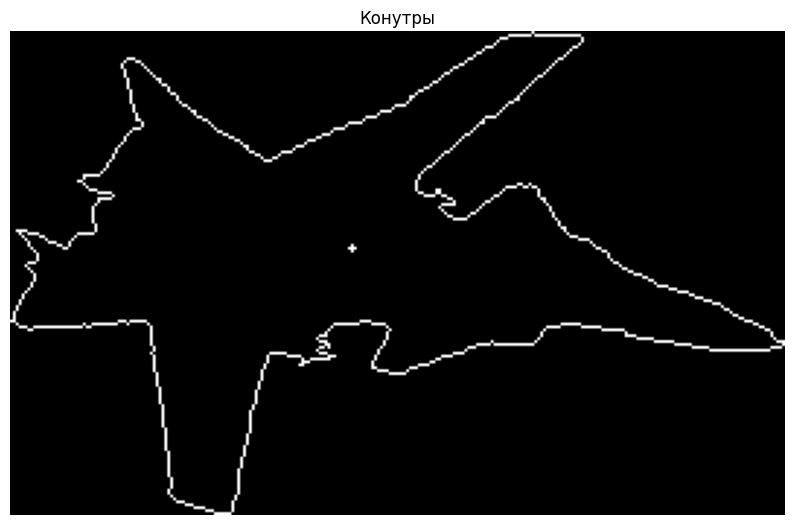

In [264]:
binary_image = binarize_image(image)
mask = np.zeros(binary_image.shape[:2], dtype=np.uint8)

contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contour = np.vstack([contour.squeeze() for contour in contours[::-1]])
center_of_gravity = np.mean(np.vstack([contour.squeeze() for contour in contours[::-1]]), axis=0)
print(f'CG = {center_of_gravity}')
cv2.drawContours(mask, contours[::-1], -1, (255), thickness=1)
cv2.circle(mask, tuple(center_of_gravity.astype(int)), 1, (255, 0, 0), -1)
x, y, w, h = cv2.boundingRect(mask)
cropped_image = mask[y:y+h, x:x+w]

# Нормализация ПЕРЕДЕЛАТЬ
# contours, _ = cv2.findContours(cropped_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# cropped_contour = np.vstack([contour.squeeze() for contour in contours[::-1]])
# normalized_contour, width, height = normalize_contour(cropped_contour, target_height=256)
# center_of_gravity = np.mean(normalized_contour, axis=0)
# print(f'CG = {center_of_gravity}')
# normalized_img = np.zeros([height, width], dtype=np.uint8)
# cv2.drawContours(normalized_img, normalized_contour, -1, (255), thickness=1)
# cv2.circle(normalized_img, tuple(center_of_gravity.astype(int)), 1, (255, 0, 0), -1)

plt.figure(figsize=(10, 10))
plt.imshow(cropped_image, cmap='gray'), plt.axis('off'), plt.title('Конутры')
plt.show()

CG = [117.05307856  74.60084926]
simplified contour has 25 points.


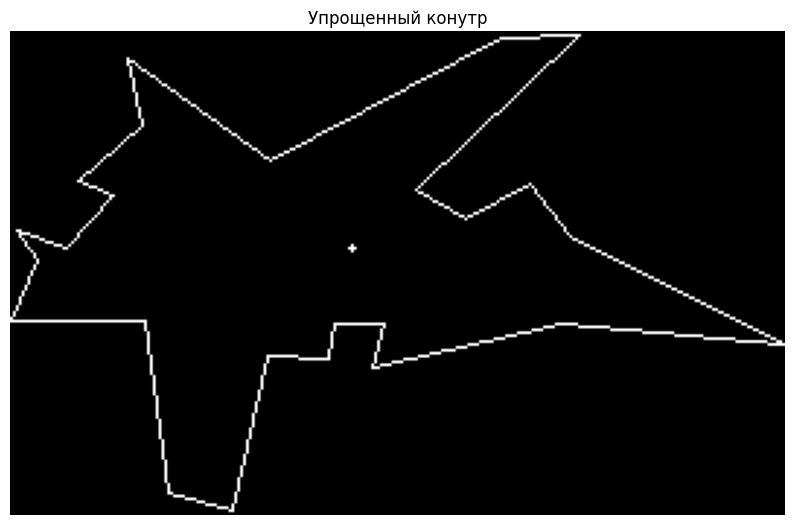

In [265]:
def simplify_contour(contour, epsilon):
    # Алгоритм Рамера — Дугласа — Пекера
    epsilon = epsilon * cv2.arcLength(contour, closed=True)
    simplified_contour = cv2.approxPolyDP(contour, epsilon, closed=True)

    return simplified_contour

contours_simple, _ = cv2.findContours(cropped_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contour_simple = np.vstack([contour.squeeze() for contour in contours_simple[::-1]])
simplified_contour = simplify_contour(contour_simple, epsilon=0.005)
simplified_contour = simplified_contour.reshape(-1, 2)
center_of_gravity = np.mean(np.vstack([contour.squeeze() for contour in contours_simple[::-1]]), axis=0)
print(f'CG = {center_of_gravity}')
print(f"simplified contour has {len(simplified_contour)} points.")

simple = np.zeros_like(cropped_image)

cv2.drawContours(simple, [simplified_contour], -1, (255, 255, 255), thickness=1)
cv2.circle(simple, tuple(center_of_gravity.astype(int)), 1, (255, 0, 0), -1)

plt.figure(figsize=(10, 10))
plt.imshow(simple, cmap='gray'), plt.axis('off'), plt.title('Упрощенный конутр')
plt.show()

In [266]:
def find_characteristic_points(contour, center_of_gravity, num_points, EPS):
    num_points = min(len(contour), num_points)

    if contour.ndim == 3:
        contour = contour.reshape(-1, 2)

    distances = np.linalg.norm(contour - center_of_gravity, axis=1)
    first_point_idx = np.argmax(distances)
    characteristic_points = [contour[first_point_idx]]

    distances = np.linalg.norm(contour - characteristic_points[0], axis=1)
    second_point_idx = np.argmax(distances)
    characteristic_points.append(contour[second_point_idx])

    while len(characteristic_points) < num_points:
        p1 = characteristic_points[-2]
        p2 = characteristic_points[-1]

        line_vector = p2 - p1
        line_length = np.linalg.norm(line_vector)

        perp_vector = np.array([-line_vector[1], line_vector[0]], dtype=np.float64)
        perp_vector /= np.linalg.norm(perp_vector)

        distances_to_line = np.abs(np.dot(contour - p1, perp_vector))

        max_distance_idx = np.argmax(distances_to_line)
        max_distance = distances_to_line[max_distance_idx]

        if max_distance / line_length < EPS:
            break

        characteristic_points.append(contour[max_distance_idx])

    return characteristic_points

In [267]:
# contours, _ = cv2.findContours(cropped_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# center_of_gravity = np.mean(np.vstack([contour.squeeze() for contour in contours[::-1]]), axis=0)
# contour = np.vstack([contour.squeeze() for contour in contours[::-1]])

characteristic_points = find_characteristic_points(simplified_contour, center_of_gravity, num_points=100, EPS=0.1)
# characteristic_points = find_characteristic_points(contour, center_of_gravity, num_points=400, EPS=0.001)
print(len(characteristic_points))

25


In [268]:
def remove_duplicates(characteristic_points):
    unique_points = []
    seen = set()
    for point in characteristic_points:
        point_tuple = tuple(point)
        if point_tuple not in seen:
            seen.add(point_tuple)
            unique_points.append(point)
    return unique_points

characteristic_points = remove_duplicates(characteristic_points)
print(len(characteristic_points))

4


In [269]:
def display_image_with_points(image, characteristic_points, center_of_gravity):
    image_copy = image.copy()
    image_copy = cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB)
    cv2.line(image_copy, tuple(center_of_gravity.astype(int)),
                               tuple(characteristic_points[0].astype(int)),
                                (255, 0, 0), 1, cv2.LINE_AA)


    for i in range(1, len(characteristic_points)):
        cv2.line(image_copy, tuple(characteristic_points[i-1].astype(int)), tuple(characteristic_points[i].astype(int)), (255, 0, 0), 1, cv2.LINE_AA)

    for i, point in enumerate(characteristic_points):
        cv2.circle(image_copy, tuple(point.astype(int)), 2, (0, 255, 0), -1)
        cv2.putText(image_copy, str(i+1), tuple(point.astype(int)),
                    cv2.FONT_HERSHEY_PLAIN, 1.0, (0, 255, 255), 1, cv2.LINE_4)

    plt.figure(figsize=(10, 10))
    plt.imshow(image_copy)
    plt.axis('off')
    plt.title('Характерные точки')
    plt.show()

4


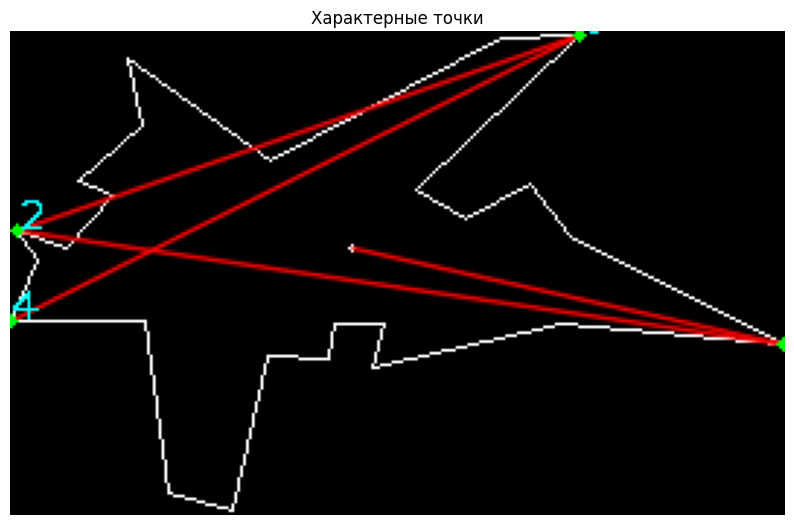

In [270]:
print(len(characteristic_points))
# display_image_with_points(cropped_image, characteristic_points, center_of_gravity)
display_image_with_points(simple, characteristic_points, center_of_gravity)

In [277]:
def edge_triplets(contour):
    edge_characteristics = []

    for i in range(len(contour)):
        p1 = contour[i]
        p2 = contour[(i + 1) % len(contour)]

        edge_length = np.linalg.norm(p2 - p1)
        prev_point = contour[i - 1]
        next_point = contour[(i + 2) % len(contour)]

        side1 = np.linalg.norm(p1 - prev_point)
        side2 = np.linalg.norm(p2 - next_point)

        N1 = edge_length / side1
        N2 = edge_length / side2

        vector1 = p1 - prev_point
        vector2 = p2 - next_point
        cross_product = np.cross(vector1, vector2)

        Z = 1 if cross_product > 0 else -1

        edge_characteristics.append((N1, N2, Z))

    return edge_characteristics

contour = simplified_contour.reshape(-1, 2)
print(len(contour))
edge_characteristics = edge_triplets(contour)

for i, (N1, N2, Z) in enumerate(edge_characteristics):
    print(f"отрезок {i+1}: N1 = {N1:.2f}, N2 = {N2:.2f}, Z = {Z}")

25
отрезок 1: N1 = 1.07, N2 = 3.59, Z = 1
отрезок 2: N1 = 0.28, N2 = 0.91, Z = 1
отрезок 3: N1 = 1.10, N2 = 1.27, Z = 1
отрезок 4: N1 = 0.79, N2 = 0.26, Z = -1
отрезок 5: N1 = 3.91, N2 = 2.85, Z = 1
отрезок 6: N1 = 0.35, N2 = 0.30, Z = 1
отрезок 7: N1 = 3.31, N2 = 1.49, Z = -1
отрезок 8: N1 = 0.67, N2 = 2.56, Z = 1
отрезок 9: N1 = 0.39, N2 = 0.81, Z = 1
отрезок 10: N1 = 1.24, N2 = 2.24, Z = 1
отрезок 11: N1 = 0.45, N2 = 0.54, Z = 1
отрезок 12: N1 = 1.85, N2 = 1.34, Z = -1
отрезок 13: N1 = 0.75, N2 = 1.48, Z = 1
отрезок 14: N1 = 0.68, N2 = 0.53, Z = 1
отрезок 15: N1 = 1.87, N2 = 0.50, Z = 1
отрезок 16: N1 = 2.01, N2 = 0.77, Z = 1
отрезок 17: N1 = 1.29, N2 = 2.61, Z = -1
отрезок 18: N1 = 0.38, N2 = 0.42, Z = 1
отрезок 19: N1 = 2.38, N2 = 2.58, Z = 1
отрезок 20: N1 = 0.39, N2 = 1.73, Z = 1
отрезок 21: N1 = 0.58, N2 = 0.72, Z = 1
отрезок 22: N1 = 1.40, N2 = 1.10, Z = 1
отрезок 23: N1 = 0.91, N2 = 0.23, Z = 1
отрезок 24: N1 = 4.30, N2 = 0.87, Z = 1
отрезок 25: N1 = 1.14, N2 = 0.93, Z = 1


In [272]:
def find_similar_object(database, edge_characteristics, characteristic_points, epsilon=0.001):
  # ПЕРЕДЕЛАТЬ НОРМАЛИЗАЦИЮ
    # normalized_points = normalize_points(characteristic_points)
    for entry in database:
        if compare_edge_characteristics(entry['edge_characteristics'], edge_characteristics):
            if compare_characteristic_points(entry['characteristic_points'], characteristic_points, epsilon):
                return entry
    return None

def compare_characteristic_points(points1, points2, epsilon):
    if len(points1) != len(points2):
        return False

    for p1, p2 in zip(points1, points2):
        distance = np.linalg.norm(np.array(p1) - np.array(p2))
        if distance > epsilon:
            return False
    return True

def compare_edge_characteristics(edges1, edges2):
    if len(edges1) != len(edges2):
        return False
    for e1, e2 in zip(edges1, edges2):
        if e1 != e2:
            return False
    return True

добавление нового объекта в базу данных

In [273]:
# database = []


# def add_to_database(database, edge_characteristics, characteristic_points, object_name):
#     for entry in database:
#         if compare_edge_characteristics(entry['edge_characteristics'], edge_characteristics):
#             return False
#     database.append({
#         'object_name': object_name,
#         'edge_characteristics': edge_characteristics,
#         'characteristic_points': characteristic_points
#     })
#     print(f'{object_name} added')
#     return True

# PATH = 'btr-80-256.jpg'
# # image = preprocess_image(image_path)
# image = cv2.imread(PATH)
# binary_image = binarize_image(image)

# contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# contour = np.vstack([contour.squeeze() for contour in contours[::-1]])
# center_of_gravity = np.mean(contour, axis=0)

# characteristic_points = find_characteristic_points(contour, center_of_gravity, num_points=400, EPS=0.001)
# edge_characteristics = edge_triplets(contour)

# object_name = "BTR-80"
# add_to_database(database, edge_characteristics, characteristic_points, object_name)

In [274]:
print(database)

[{'object_name': 'Berkut', 'edge_characteristics': [(0.5, 0.35355339059327373, 1), (2.8284271247461903, 2.8284271247461903, -1), (0.35355339059327373, 0.35355339059327373, -1), (2.8284271247461903, 2.8284271247461903, -1), (0.35355339059327373, 0.35355339059327373, -1), (2.8284271247461903, 1.4142135623730951, -1), (0.7071067811865475, 0.7071067811865475, -1), (1.4142135623730951, 2.8284271247461903, -1), (0.35355339059327373, 0.35355339059327373, -1), (2.8284271247461903, 2.8284271247461903, -1), (0.35355339059327373, 0.23570226039551587, -1), (4.242640687119285, 4.242640687119285, -1), (0.23570226039551587, 0.23570226039551587, -1), (4.242640687119285, 4.242640687119285, -1), (0.23570226039551587, 0.23570226039551587, -1), (4.242640687119285, 4.242640687119285, -1), (0.23570226039551587, 0.35355339059327373, -1), (2.8284271247461903, 2.8284271247461903, -1), (0.35355339059327373, 0.35355339059327373, -1), (2.8284271247461903, 2.8284271247461903, -1), (0.35355339059327373, 0.235702260

In [275]:
similar_object = find_similar_object(database, edge_characteristics, characteristic_points)
if similar_object:
    print(f"Объект найден: {similar_object}")
else:
    print("Объект не найден")

Объект не найден


In [276]:
# if __name__ == "__main__":
#     main()